In [1]:
from Bio import SeqIO
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
fn = 'data/spikeprot0430/spikeprot0430.fasta'

In [9]:
d = {'Gene': [], 'Date': [], 'Location': [], 'Sequence': []}
max_per_month = 100  # arbitrary lol
month_counts = defaultdict(int)


record_iterator = SeqIO.parse(fn, "fasta")

for i in tqdm(range(2*10**8)):
    try:
        record = next(record_iterator)
        fields = record.description.split("|")
        (gene, isolate, date, iso_id, passage,
        type_loc, host, o_lab, s_lab,
        submitter, location) = (fields + ["?"]*11)[:11]
        
        virus_type, state = type_loc.split("^^") if "^^" in type_loc else (type_loc, "?")
        
        if date[5:7] != '00' and date[-2:] != '00' and date[4] == '-':
            month_loc = date[:7]+location  # yyyy-mm
            if month_counts[month_loc] < max_per_month:
                d['Gene'].append(gene)
                d['Date'].append(date)
                d['Location'].append(location)
                d['Sequence'].append(str(record.seq))
                month_counts[month_loc] += 1
    except:
        continue

  0%|          | 0/200000000 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame(d)
df = df[df['Location'] != '?']

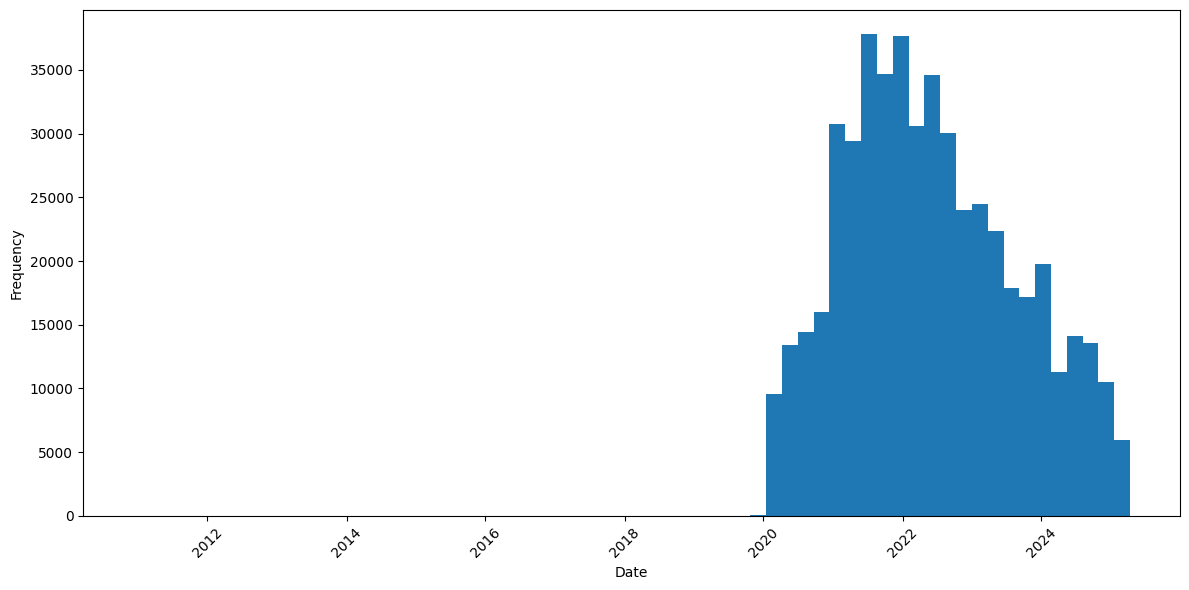

In [11]:
# Assuming your DataFrame is called df
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(df['Date'], bins=63)  # You can adjust the number of bins
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df['Month'] = df['Date'].dt.to_period('M')

(array([1.424e+03, 7.150e+02, 5.140e+02, 3.910e+02, 3.600e+02, 2.700e+02,
        2.340e+02, 2.080e+02, 1.780e+02, 1.790e+02, 1.430e+02, 1.210e+02,
        1.230e+02, 1.200e+02, 1.110e+02, 9.100e+01, 1.100e+02, 8.200e+01,
        7.500e+01, 6.400e+01, 8.200e+01, 6.700e+01, 6.600e+01, 6.000e+01,
        6.000e+01, 6.000e+01, 4.100e+01, 5.700e+01, 5.200e+01, 4.500e+01,
        4.300e+01, 4.800e+01, 3.700e+01, 3.700e+01, 4.500e+01, 4.400e+01,
        4.000e+01, 4.200e+01, 3.800e+01, 3.300e+01, 2.700e+01, 3.500e+01,
        4.100e+01, 4.300e+01, 3.400e+01, 2.700e+01, 2.700e+01, 3.000e+01,
        2.100e+01, 3.533e+03, 1.200e+01, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

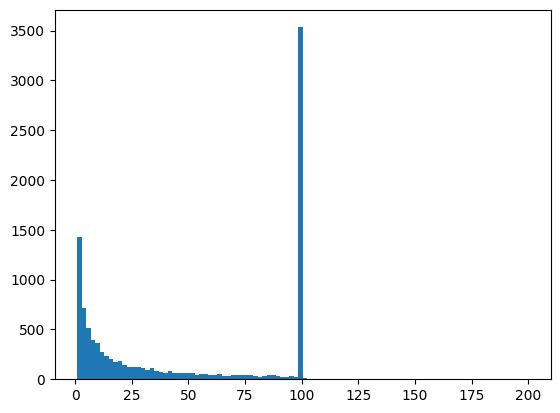

In [16]:
plt.hist(df.groupby(['Location','Month']).count()['Gene'], bins=100)